# Machine Learning: Modelo supervisado de regresión

In [544]:
# Importar librerías

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error

## Lectura de datos

In [545]:
diamonds_train = pd.read_csv('./data/diamonds_train.csv')
diamonds_train.head()

,price,carat,depth,table,x,y,z,cut,color,clarity,city
0,4268,1.21,62.4,58.0,6.83,6.79,4.25,Premium,J,VS2,Dubai
1,505,0.32,63.0,57.0,4.35,4.38,2.75,Very Good,H,VS2,Kimberly
2,2686,0.71,65.5,55.0,5.62,5.53,3.65,Fair,G,VS1,Las Vegas
3,738,0.41,63.8,56.0,4.68,4.72,3.00,Good,D,SI1,Kimberly
4,4882,1.02,60.5,59.0,6.55,6.51,3.95,Ideal,G,SI1,Dubai


In [546]:
columnas_reordenadas = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z', 'city', 'price']
diamonds_train = diamonds_train[columnas_reordenadas]
diamonds_train

,carat,cut,color,clarity,depth,table,x,y,z,city,price
0,1.21,Premium,J,VS2,62.4,58.0,6.83,6.79,4.25,Dubai,4268
1,0.32,Very Good,H,VS2,63.0,57.0,4.35,4.38,2.75,Kimberly,505
2,0.71,Fair,G,VS1,65.5,55.0,5.62,5.53,3.65,Las Vegas,2686
3,0.41,Good,D,SI1,63.8,56.0,4.68,4.72,3.00,Kimberly,738
4,1.02,Ideal,G,SI1,60.5,59.0,6.55,6.51,3.95,Dubai,4882
...,...,...,...,...,...,...,...,...,...,...,...
40450,1.34,Ideal,G,VS1,62.7,57.0,7.10,7.04,4.43,Antwerp,10070
40451,2.02,Good,F,SI2,57.1,60.0,8.31,8.25,4.73,Madrid,12615
40452,1.01,Ideal,H,SI1,62.7,56.0,6.37,6.42,4.01,Kimberly,5457
40453,0.33,Ideal,J,VS1,61.9,54.3,4.45,4.47,2.76,Kimberly,456


## Análisis exploratorio

### General

In [547]:
diamonds_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    40455 non-null  float64
 1   cut      40455 non-null  object 
 2   color    40455 non-null  object 
 3   clarity  40455 non-null  object 
 4   depth    40455 non-null  float64
 5   table    40455 non-null  float64
 6   x        40455 non-null  float64
 7   y        40455 non-null  float64
 8   z        40455 non-null  float64
 9   city     40455 non-null  object 
 10  price    40455 non-null  int64  
dtypes: float64(6), int64(1), object(4)
memory usage: 3.4+ MB


In [548]:
def cat_var(df, cols):
    '''
    Return: a Pandas dataframe object with the following columns:
        - "categorical_variable" => every categorical variable include as an input parameter (string).
        - "number_of_possible_values" => the amount of unique values that can take a given categorical variable (integer).
        - "values" => a list with the posible unique values for every categorical variable (list).

    Input parameters:
        - df -> Pandas dataframe object: a dataframe with categorical variables.
        - cols -> list object: a list with the name (string) of every categorical variable to analyse.
    '''
    cat_list = []
    for col in cols:
        cat = df[col].unique()
        cat_num = len(cat)
        cat_dict = {"categorical_variable":col,
                    "number_of_possible_values":cat_num,
                    "values":cat}
        cat_list.append(cat_dict)
    df = pd.DataFrame(cat_list).sort_values(by="number_of_possible_values", ascending=False)
    return df.reset_index(drop=True)

In [549]:
col_diamonds_train = list(diamonds_train.columns)
cat_diamonds_train = cat_var(diamonds_train, col_diamonds_train)
cat_diamonds_train

,categorical_variable,number_of_possible_values,values
0,price,10378,"[4268, 505, 2686, 738, 4882, 9057, 3733, 8608,..."
1,x,543,"[6.83, 4.35, 5.62, 4.68, 6.55, 7.45, 6.23, 7.3..."
2,y,539,"[6.79, 4.38, 5.53, 4.72, 6.51, 7.39, 6.19, 7.3..."
3,z,363,"[4.25, 2.75, 3.65, 3.0, 3.95, 4.54, 4.05, 4.57..."
4,carat,270,"[1.21, 0.32, 0.71, 0.41, 1.02, 1.52, 1.01, 0.3..."
5,depth,175,"[62.4, 63.0, 65.5, 63.8, 60.5, 61.2, 65.2, 62...."
6,table,121,"[58.0, 57.0, 55.0, 56.0, 59.0, 54.2, 63.0, 61...."
7,city,13,"[Dubai, Kimberly, Las Vegas, Tel Aviv, Amsterd..."
8,clarity,8,"[VS2, VS1, SI1, SI2, IF, VVS1, VVS2, I1]"
9,color,7,"[J, H, G, D, F, E, I]"


In [550]:
diamonds_train.eq(0).sum()

carat       0
cut         0
color       0
clarity     0
depth       0
table       0
x           5
y           4
z          16
city        0
price       0
dtype: int64

In [552]:
diamonds_train[(diamonds_train == 0).any(axis=1)]

,carat,cut,color,clarity,depth,table,x,y,z,city,price
1606,1.01,Premium,F,SI2,59.2,58.0,6.50,6.47,0.0,New York City,3837
3945,2.02,Premium,H,VS2,62.7,53.0,8.02,7.95,0.0,Madrid,18207
6465,0.71,Good,F,SI2,64.1,60.0,0.00,0.00,0.0,Madrid,2130
13839,2.80,Good,G,SI2,63.8,58.0,8.90,8.85,0.0,Kimberly,18788
14815,1.07,Ideal,F,SI2,61.6,56.0,0.00,6.62,0.0,Kimberly,4954
14891,2.18,Premium,H,SI2,59.4,61.0,8.49,8.45,0.0,Surat,12631
16425,2.20,Premium,H,SI1,61.2,59.0,8.42,8.37,0.0,Surat,17265
19856,1.00,Premium,G,SI2,59.1,59.0,6.55,6.48,0.0,Madrid,3142
21602,1.15,Ideal,G,VS2,59.2,56.0,6.88,6.83,0.0,New York City,5564
24795,1.10,Premium,G,SI2,63.0,59.0,6.50,6.47,0.0,Dubai,3696


In [553]:
# TRANSFORMAR X
# Calcular la media agrupando por el campo 'carat'
mediana_por_carat = diamonds_train.groupby('carat')['x'].transform('median')

# Rellenar los valores en 'x' con la media correspondiente cuando 'x' es igual a 0
diamonds_train.loc[diamonds_train['x'] == 0, 'x'] = mediana_por_carat

# TRANSFORMAR Y
# Calcular la media agrupando por el campo 'carat'
mediana_por_carat = diamonds_train.groupby('carat')['y'].transform('median')

# Rellenar los valores en 'x' con la media correspondiente cuando 'x' es igual a 0
diamonds_train.loc[diamonds_train['y'] == 0, 'y'] = mediana_por_carat

# TRANSFORMAR Z
# Calcular la media agrupando por el campo 'carat'
mediana_por_carat = diamonds_train.groupby('carat')['z'].transform('median')

# Rellenar los valores en 'x' con la media correspondiente cuando 'x' es igual a 0
diamonds_train.loc[diamonds_train['z'] == 0, 'z'] = mediana_por_carat



In [554]:
diamonds_train.loc[6465]

carat        0.71
cut          Good
color           F
clarity       SI2
depth        64.1
table        60.0
x            5.71
y            5.73
z            3.54
city       Madrid
price        2130
Name: 6465, dtype: object

In [555]:
diamonds_train[(diamonds_train == 0).any(axis=1)]

,carat,cut,color,clarity,depth,table,x,y,z,city,price


In [556]:
diamonds_train.eq(0).sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
city       0
price      0
dtype: int64

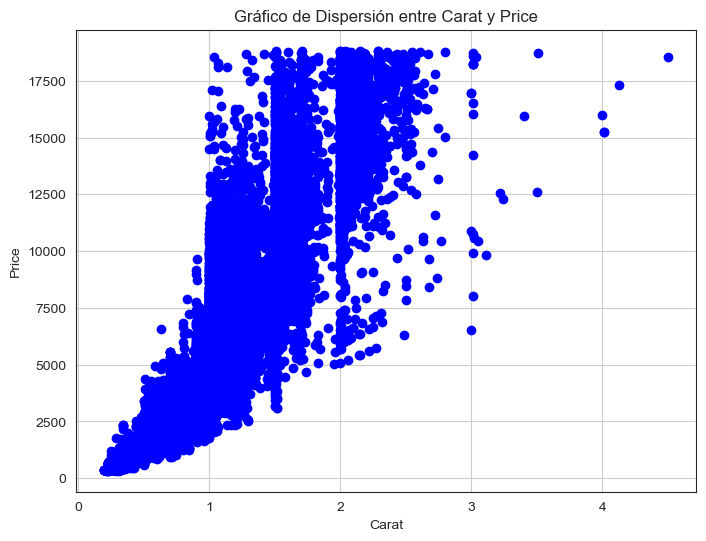

In [557]:
# Crear un gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(diamonds_train['carat'], diamonds_train['price'], alpha=1, color='blue')

# Personalizar el gráfico
plt.title('Gráfico de Dispersión entre Carat y Price')
plt.xlabel('Carat')
plt.ylabel('Price')
plt.grid(True)

# Mostrar el gráfico
plt.show()

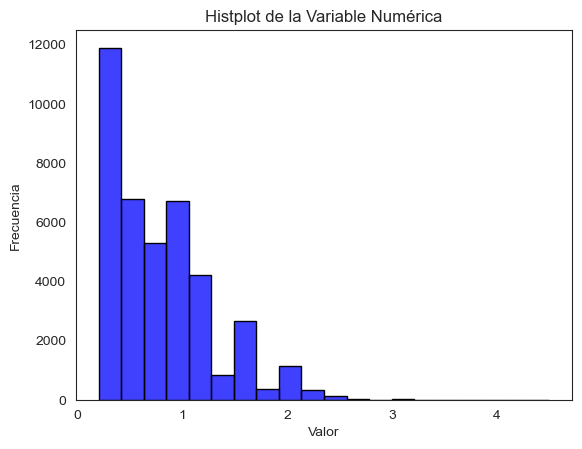

In [558]:
# Crear un histplot
sns.histplot(data=diamonds_train, x='carat', bins=20, kde=False, color='blue', edgecolor='black')

# Personalizar el gráfico
plt.title('Histplot de la Variable Numérica')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()


### Variables categóricas

In [559]:
diamonds_train['cut'].value_counts()
# Habría que darles una ordinalidad de mejor a peor: Premium, Ideal, Very Good, Good, Fair (5-1)

cut
Ideal        16220
Premium      10260
Very Good     9095
Good          3663
Fair          1217
Name: count, dtype: int64

In [560]:
diamonds_train['clarity'].value_counts()
# Se podrían agrupar por tipo de claridad

clarity
SI1     9749
VS2     9248
SI2     6929
VS1     6066
VVS2    3799
VVS1    2774
IF      1327
I1       563
Name: count, dtype: int64

In [561]:
diamonds_train['city'].value_counts()
# Se podría agrupar por continente

city
Surat            5073
Antwerp          5047
Kimberly         4976
Luxembourg       2606
Las Vegas        2586
New York City    2586
Dubai            2561
Madrid           2540
Paris            2530
Tel Aviv         2505
Zurich           2497
Amsterdam        2485
London           2463
Name: count, dtype: int64

In [562]:
diamonds_train['color'].value_counts()

color
G    8455
E    7325
F    7177
H    6277
D    5049
I    4032
J    2140
Name: count, dtype: int64

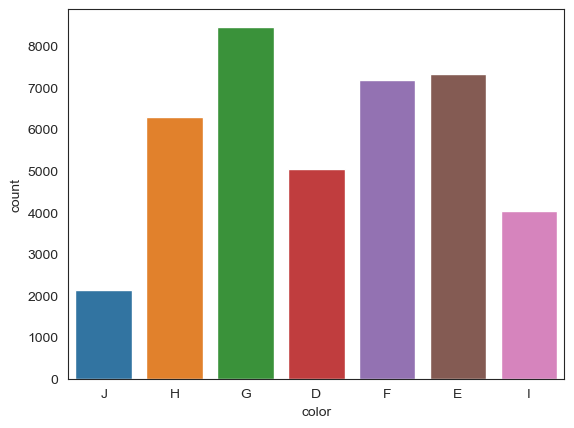

In [563]:
sns.countplot(x='color', data=diamonds_train)
plt.show()

In [564]:
diamonds_train.groupby('color')['price'].mean()

color
D    3134.943157
E    3088.342526
F    3677.355720
G    4023.214902
H    4476.469014
I    5090.868800
J    5346.234112
Name: price, dtype: float64

### Variables numéricas

In [565]:
diamonds_train.describe()

,carat,depth,table,x,y,z,price
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000
mean,0.797706,61.752841,57.446133,5.730212,5.733475,3.538845,3928.444469
std,0.475544,1.431725,2.233535,1.122748,1.145318,0.693793,3992.416147
min,0.200000,43.000000,43.000000,3.770000,3.720000,1.070000,326.000000
25%,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000,945.000000
50%,0.700000,61.800000,57.000000,5.690000,5.710000,3.520000,2397.000000
75%,1.040000,62.500000,59.000000,6.540000,6.540000,4.040000,5331.000000
max,4.500000,79.000000,95.000000,10.230000,58.900000,8.060000,18823.000000


In [566]:
diamonds_train_num = diamonds_train.select_dtypes(include=['number'])
diamonds_train_num

,carat,depth,table,x,y,z,price
0,1.21,62.4,58.0,6.83,6.79,4.25,4268
1,0.32,63.0,57.0,4.35,4.38,2.75,505
2,0.71,65.5,55.0,5.62,5.53,3.65,2686
3,0.41,63.8,56.0,4.68,4.72,3.00,738
4,1.02,60.5,59.0,6.55,6.51,3.95,4882
...,...,...,...,...,...,...,...
40450,1.34,62.7,57.0,7.10,7.04,4.43,10070
40451,2.02,57.1,60.0,8.31,8.25,4.73,12615
40452,1.01,62.7,56.0,6.37,6.42,4.01,5457
40453,0.33,61.9,54.3,4.45,4.47,2.76,456


/var/folders/q9/jr4dd24n26j12ng25b__0q6c0000gn/T/ipykernel_744/2176291584.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(diamonds_train['price'], color="b");


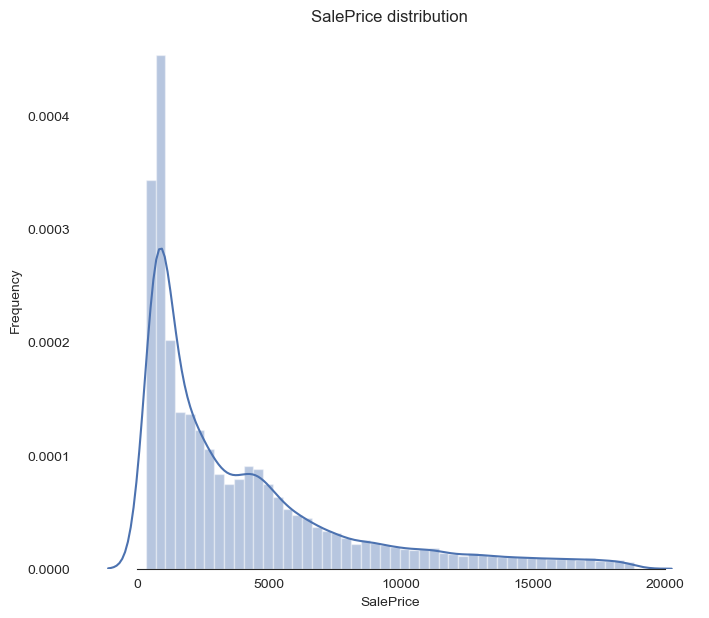

In [567]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
#Check the new distribution 
sns.distplot(diamonds_train['price'], color="b");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

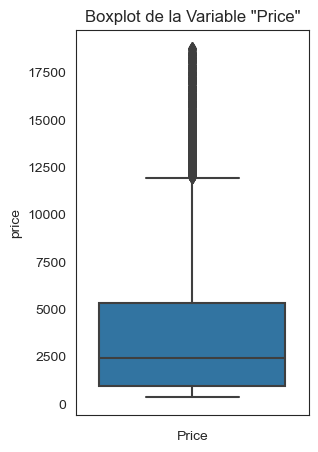

In [568]:
# Configurar el tamaño de la figura
plt.figure(figsize=(3, 5))

# Crear un boxplot para la variable "price"
sns.boxplot(y=diamonds_train['price'])

# Añadir etiquetas y título
plt.xlabel('Price')
plt.title('Boxplot de la Variable "Price"')

# Mostrar el gráfico
plt.show()

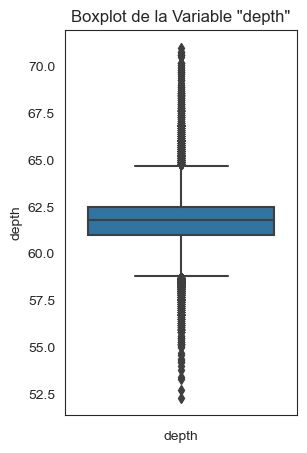

In [569]:
# Configurar el tamaño de la figura
plt.figure(figsize=(3, 5))

# Crear un boxplot para la variable "price"
sns.boxplot(y=diamonds_train1['depth'])

# Añadir etiquetas y título
plt.xlabel('depth')
plt.title('Boxplot de la Variable "depth"')

# Mostrar el gráfico
plt.show()


In [570]:

# Calcular el rango intercuartílico (IQR)
Q1 = diamonds_train['depth'].quantile(0.25)
Q3 = diamonds_train['depth'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para identificar outliers
limite_inferior = Q1 - 10 * IQR
#limite_superior = Q3 + 1.5 * IQR

# Filtrar los datos para eliminar outliers
diamonds_train = diamonds_train[(diamonds_train['depth'] >= limite_inferior) & (diamonds_train['depth'] <= limite_superior)]

# Visualizar el DataFrame resultante sin outliers
diamonds_train

,carat,cut,color,clarity,depth,table,x,y,z,city,price
0,1.21,Premium,J,VS2,62.4,58.0,6.83,6.79,4.25,Dubai,4268
1,0.32,Very Good,H,VS2,63.0,57.0,4.35,4.38,2.75,Kimberly,505
2,0.71,Fair,G,VS1,65.5,55.0,5.62,5.53,3.65,Las Vegas,2686
3,0.41,Good,D,SI1,63.8,56.0,4.68,4.72,3.00,Kimberly,738
4,1.02,Ideal,G,SI1,60.5,59.0,6.55,6.51,3.95,Dubai,4882
...,...,...,...,...,...,...,...,...,...,...,...
40450,1.34,Ideal,G,VS1,62.7,57.0,7.10,7.04,4.43,Antwerp,10070
40451,2.02,Good,F,SI2,57.1,60.0,8.31,8.25,4.73,Madrid,12615
40452,1.01,Ideal,H,SI1,62.7,56.0,6.37,6.42,4.01,Kimberly,5457
40453,0.33,Ideal,J,VS1,61.9,54.3,4.45,4.47,2.76,Kimberly,456


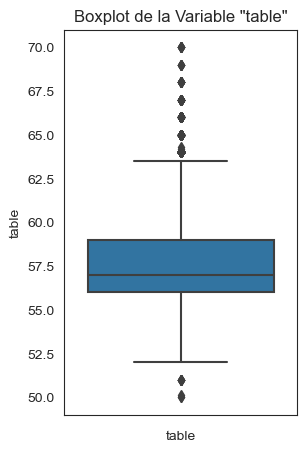

In [573]:
# Configurar el tamaño de la figura
plt.figure(figsize=(3, 5))

# Crear un boxplot para la variable "price"
sns.boxplot(y=diamonds_train['table'])

# Añadir etiquetas y título
plt.xlabel('table')
plt.title('Boxplot de la Variable "table"')

# Mostrar el gráfico
plt.show()


In [572]:

# Calcular el rango intercuartílico (IQR)
Q1 = diamonds_train['table'].quantile(0.25)
Q3 = diamonds_train['table'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para identificar outliers
limite_inferior = Q1 - 2 * IQR
limite_superior = Q3 + 4 * IQR

# Filtrar los datos para eliminar outliers
diamonds_train = diamonds_train[(diamonds_train['table'] >= limite_inferior) & (diamonds_train['table'] <= limite_superior)]

# Visualizar el DataFrame resultante sin outliers
diamonds_train

,carat,cut,color,clarity,depth,table,x,y,z,city,price
0,1.21,Premium,J,VS2,62.4,58.0,6.83,6.79,4.25,Dubai,4268
1,0.32,Very Good,H,VS2,63.0,57.0,4.35,4.38,2.75,Kimberly,505
2,0.71,Fair,G,VS1,65.5,55.0,5.62,5.53,3.65,Las Vegas,2686
3,0.41,Good,D,SI1,63.8,56.0,4.68,4.72,3.00,Kimberly,738
4,1.02,Ideal,G,SI1,60.5,59.0,6.55,6.51,3.95,Dubai,4882
...,...,...,...,...,...,...,...,...,...,...,...
40450,1.34,Ideal,G,VS1,62.7,57.0,7.10,7.04,4.43,Antwerp,10070
40451,2.02,Good,F,SI2,57.1,60.0,8.31,8.25,4.73,Madrid,12615
40452,1.01,Ideal,H,SI1,62.7,56.0,6.37,6.42,4.01,Kimberly,5457
40453,0.33,Ideal,J,VS1,61.9,54.3,4.45,4.47,2.76,Kimberly,456


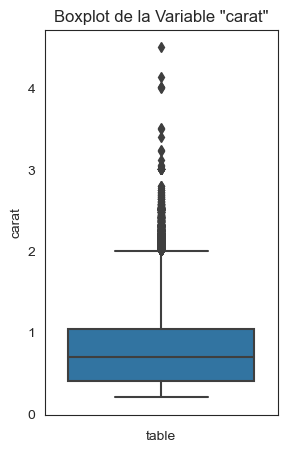

In [574]:
# Configurar el tamaño de la figura
plt.figure(figsize=(3, 5))

# Crear un boxplot para la variable "price"
sns.boxplot(y=diamonds_train['carat'])

# Añadir etiquetas y título
plt.xlabel('table')
plt.title('Boxplot de la Variable "carat"')

# Mostrar el gráfico
plt.show()

In [575]:

# Calcular el rango intercuartílico (IQR)
#Q1 = diamonds_train['carat'].quantile(0.25)
#Q3 = diamonds_train['carat'].quantile(0.75)
#IQR = Q3 - Q1

# Definir límites para identificar outliers
#limite_inferior = Q1 - 1.75 * IQR
#limite_superior = Q3 + 1.75 * IQR

# Filtrar los datos para eliminar outliers
#diamonds_train = diamonds_train[(diamonds_train['carat'] <= limite_superior)]

# Visualizar el DataFrame resultante sin outliers
#diamonds_train

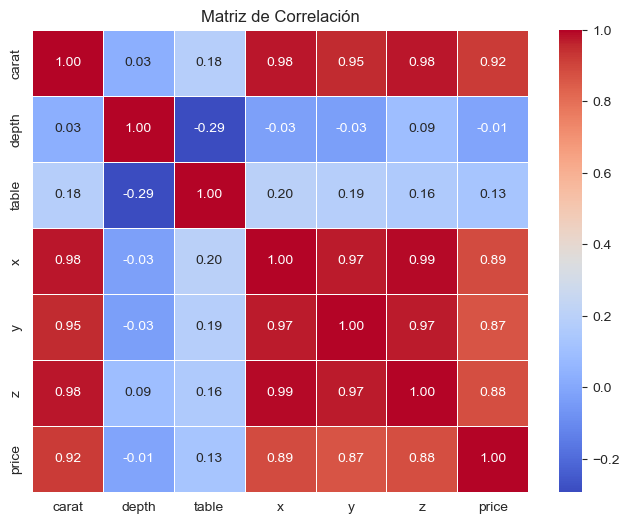

In [576]:
# Calcular la matriz de correlación
correlation_matrix = diamonds_train_num.corr()

# Configurar el tamaño de la figura
plt.figure(figsize=(8, 6))

# Crear un mapa de calor (heatmap) con seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Añadir título
plt.title('Matriz de Correlación')

# Mostrar el gráfico
plt.show()

In [410]:
# x, y, z muy correlacionadas. Habría que eliminar dos variables o hacer una media de las 3.
# carat también muy correlacionada. Se puede eliminar o quizás habría que mantenerla porque está muy correlacionada con price
# Eliminar la variable depth porque apenas tiene correlacion con la variable target y hay muchos outliers (ruido)

## Transformación de variables

### Eliminación variables

In [506]:
# Probamos con hacer una media entre x, y, z:
#diamonds_train['mean'] = diamonds_train['x'] * diamonds_train['y'] * diamonds_train['z']
#diamonds_train['mean'] = diamonds_train[['x','y','z']].mean(axis=1)
#diamonds_train['mean']

In [507]:
#diamonds_train['mean_carat'] = diamonds_train['mean'] * diamonds_train['carat']

In [577]:
diamonds_train_num = diamonds_train.select_dtypes(include=['number'])
diamonds_train_num

,carat,depth,table,x,y,z,price
0,1.21,62.4,58.0,6.83,6.79,4.25,4268
1,0.32,63.0,57.0,4.35,4.38,2.75,505
2,0.71,65.5,55.0,5.62,5.53,3.65,2686
3,0.41,63.8,56.0,4.68,4.72,3.00,738
4,1.02,60.5,59.0,6.55,6.51,3.95,4882
...,...,...,...,...,...,...,...
40450,1.34,62.7,57.0,7.10,7.04,4.43,10070
40451,2.02,57.1,60.0,8.31,8.25,4.73,12615
40452,1.01,62.7,56.0,6.37,6.42,4.01,5457
40453,0.33,61.9,54.3,4.45,4.47,2.76,456


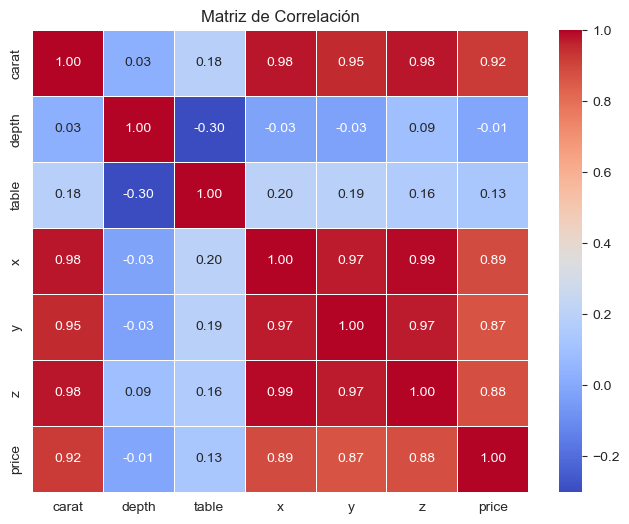

In [578]:
# Calcular la matriz de correlación
correlation_matrix = diamonds_train_num.corr()

# Configurar el tamaño de la figura
plt.figure(figsize=(8, 6))

# Crear un mapa de calor (heatmap) con seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Añadir título
plt.title('Matriz de Correlación')

# Mostrar el gráfico
plt.show()

In [579]:
diamonds_train.describe()

,carat,depth,table,x,y,z,price
count,40436.000000,40436.000000,40436.000000,40436.000000,40436.000000,40436.000000,40436.000000
mean,0.797652,61.752011,57.444463,5.730119,5.733424,3.538671,3928.682140
std,0.475579,1.413778,2.214379,1.122839,1.145418,0.693794,3992.918247
min,0.200000,52.300000,50.000000,3.770000,3.720000,1.070000,326.000000
25%,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000,945.000000
50%,0.700000,61.800000,57.000000,5.690000,5.710000,3.520000,2396.500000
75%,1.040000,62.500000,59.000000,6.540000,6.540000,4.040000,5331.250000
max,4.500000,71.000000,70.000000,10.230000,58.900000,8.060000,18823.000000


In [580]:
# Eliminación de variables x, y , z y depth
diamonds_train = diamonds_train.drop(columns=['city'])
diamonds_train

,carat,cut,color,clarity,depth,table,x,y,z,price
0,1.21,Premium,J,VS2,62.4,58.0,6.83,6.79,4.25,4268
1,0.32,Very Good,H,VS2,63.0,57.0,4.35,4.38,2.75,505
2,0.71,Fair,G,VS1,65.5,55.0,5.62,5.53,3.65,2686
3,0.41,Good,D,SI1,63.8,56.0,4.68,4.72,3.00,738
4,1.02,Ideal,G,SI1,60.5,59.0,6.55,6.51,3.95,4882
...,...,...,...,...,...,...,...,...,...,...
40450,1.34,Ideal,G,VS1,62.7,57.0,7.10,7.04,4.43,10070
40451,2.02,Good,F,SI2,57.1,60.0,8.31,8.25,4.73,12615
40452,1.01,Ideal,H,SI1,62.7,56.0,6.37,6.42,4.01,5457
40453,0.33,Ideal,J,VS1,61.9,54.3,4.45,4.47,2.76,456


In [581]:
# Label encoder
def ordinal_encoding(x):
    for key in encoding:
        if x == key:
            return encoding[key]

In [582]:
# Label Encoding variable clarity
encoding = {'IF': 8, 'VVS1':7, 'VVS2':6, 'VS1':5, 'VS2':4, 'SI1':3, 'SI2':2, 'I1':1}
diamonds_train['clarity'] = diamonds_train['clarity'].apply(ordinal_encoding)
# Label Encoding variable cut
encoding = {'Premium': 4, 'Ideal':5, 'Very Good':3, 'Good':2, 'Fair':1}
diamonds_train['cut'] = diamonds_train['cut'].apply(ordinal_encoding)
# Label Encoding variable cut
encoding = {'D': 7, 'E':6, 'F':5, 'G':4, 'H':3, 'I':2, 'J':1}
diamonds_train['color'] = diamonds_train['color'].apply(ordinal_encoding)

In [513]:

# Inicializar el LabelEncoder
#label_encoder = LabelEncoder()

# Ajustar y transformar las etiquetas categóricas

#diamonds_train['color'] = label_encoder.fit_transform(diamonds_train['color'])


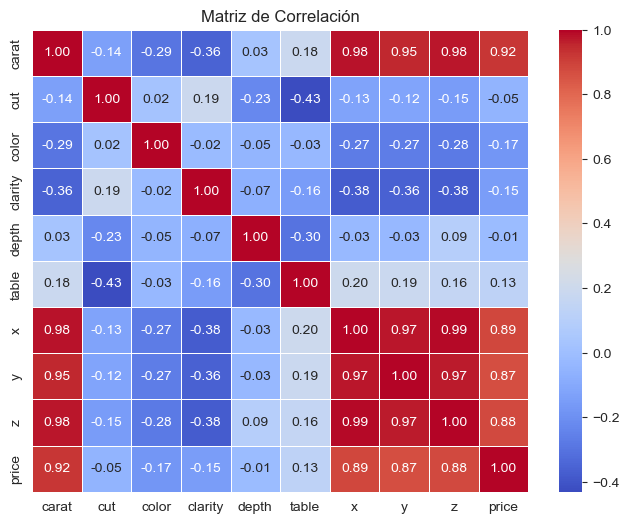

In [583]:
# Calcular la matriz de correlación
correlation_matrix = diamonds_train.corr()

# Configurar el tamaño de la figura
plt.figure(figsize=(8, 6))

# Crear un mapa de calor (heatmap) con seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Añadir título
plt.title('Matriz de Correlación')

# Mostrar el gráfico
plt.show()

In [584]:
# Nos quedamos con todo menos el target
diamonds_train_x = diamonds_train.drop(columns=['price'])

In [585]:
diamonds_train_y = diamonds_train['price']
diamonds_train_y

0         4268
1          505
2         2686
3          738
4         4882
         ...  
40450    10070
40451    12615
40452     5457
40453      456
40454     6232
Name: price, Length: 40436, dtype: int64

### Escalado

In [586]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(diamonds_train_x)
diamonds_train_x_scaled = pd.DataFrame(scaled_data)
diamonds_train_x_scaled

,0,1,2,3,4,5,6,7,8
0,0.234884,0.75,0.000000,0.428571,0.540107,0.400,0.473684,0.055636,0.454936
1,0.027907,0.50,0.333333,0.428571,0.572193,0.350,0.089783,0.011961,0.240343
2,0.118605,0.00,0.500000,0.571429,0.705882,0.250,0.286378,0.032802,0.369099
3,0.048837,0.25,1.000000,0.285714,0.614973,0.300,0.140867,0.018123,0.276109
4,0.190698,1.00,0.500000,0.285714,0.438503,0.450,0.430341,0.050562,0.412017
...,...,...,...,...,...,...,...,...,...
40431,0.265116,1.00,0.500000,0.571429,0.556150,0.350,0.515480,0.060167,0.480687
40432,0.423256,0.25,0.666667,0.142857,0.256684,0.500,0.702786,0.082095,0.523605
40433,0.188372,1.00,0.333333,0.285714,0.556150,0.300,0.402477,0.048931,0.420601
40434,0.030233,1.00,0.000000,0.571429,0.513369,0.215,0.105263,0.013592,0.241774


## Modelado

### Random Forest

In [600]:
%%time

model_random = RandomForestRegressor(random_state = 42)


scores = cross_val_score(model_random, 
                         diamonds_train_x, 
                         diamonds_train_y, 
                         scoring='neg_root_mean_squared_error', 
                         cv=5,
                         n_jobs=-1)

print(scores, '\n')
print(np.mean(-scores), '\n')

[-536.57750742 -548.62009901 -544.68972633 -571.00617445 -538.13901907] 

547.8065052554173 

CPU times: user 195 ms, sys: 155 ms, total: 350 ms
Wall time: 53.9 s


### XGBRegressor

In [ ]:
model_xgb = XGBRegressor(colsample_bytree = 0.95,
                          gamma = 0.14,
                          learning_rate = 0.012,
                          max_depth = 7,
                          missing = np.inf,
                          n_estimators = 1130,
                          subsample = 0.8, 
                         objective='reg:squarederror', random_state=42)

### RMSE - Cross Validation

In [599]:
%%time


scores = cross_val_score(model_random, 
                         diamonds_train_x, 
                         diamonds_train_y, 
                         scoring='neg_root_mean_squared_error', 
                         cv=5,
                         n_jobs=-1)

print(scores, '\n')
print(np.mean(-scores), '\n')

KeyboardInterrupt: 

## Test

In [588]:
diamonds_test_x = pd.read_csv('./data/diamonds_test.csv')
diamonds_test_x.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,city
0,0,0.79,Very Good,F,SI1,62.7,60.0,5.82,5.89,3.67,Amsterdam
1,1,1.20,Ideal,J,VS1,61.0,57.0,6.81,6.89,4.18,Surat
2,2,1.57,Premium,H,SI1,62.2,61.0,7.38,7.32,4.57,Kimberly
3,3,0.90,Very Good,F,SI1,63.8,54.0,6.09,6.13,3.90,Kimberly
4,4,0.50,Very Good,F,VS1,62.9,58.0,5.05,5.09,3.19,Amsterdam


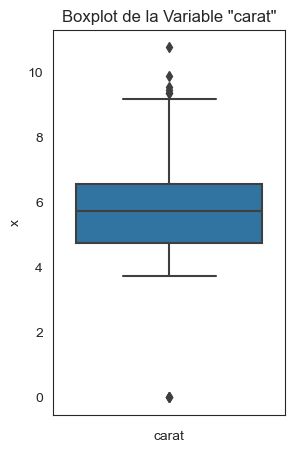

In [589]:
# Configurar el tamaño de la figura
plt.figure(figsize=(3, 5))

# Crear un boxplot para la variable "price"
sns.boxplot(y=diamonds_test_x['x'])

# Añadir etiquetas y título
plt.xlabel('carat')
plt.title('Boxplot de la Variable "carat"')

# Mostrar el gráfico
plt.show()

In [590]:
diamonds_test_x.eq(0).sum()

id         1
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          3
y          3
z          4
city       0
dtype: int64

In [591]:
# Probamos con hacer una media entre x, y, z:
#diamonds_test_x['mean'] = diamonds_test_x[['x','y','z']].mean(axis=1)
# Eliminacion de columnas id, x, y, z
diamonds_test_x = diamonds_test_x.drop(columns=['id','city'])
# Label Encoding variable clarity
encoding = {'IF': 8, 'VVS1':7, 'VVS2':6, 'VS1':5, 'VS2':4, 'SI1':3, 'SI2':2, 'I1':1}
diamonds_test_x['clarity'] = diamonds_test_x['clarity'].apply(ordinal_encoding)
# Label Encoding variable cut
encoding = {'Premium': 4, 'Ideal':5, 'Very Good':3, 'Good':2, 'Fair':1}
diamonds_test_x['cut'] = diamonds_test_x['cut'].apply(ordinal_encoding)
# Label Encoding variable cut
encoding = {'D': 7, 'E':6, 'F':5, 'G':4, 'H':3, 'I':2, 'J':1}
diamonds_test_x['color'] = diamonds_test_x['color'].apply(ordinal_encoding)
diamonds_test_x

,carat,cut,color,clarity,depth,table,x,y,z
0,0.79,3,5,3,62.7,60.0,5.82,5.89,3.67
1,1.20,5,1,5,61.0,57.0,6.81,6.89,4.18
2,1.57,4,3,3,62.2,61.0,7.38,7.32,4.57
3,0.90,3,5,3,63.8,54.0,6.09,6.13,3.90
4,0.50,3,5,5,62.9,58.0,5.05,5.09,3.19
...,...,...,...,...,...,...,...,...,...
13480,0.57,5,6,3,61.9,56.0,5.35,5.32,3.30
13481,0.71,5,2,4,62.2,55.0,5.71,5.73,3.56
13482,0.70,5,5,5,61.6,55.0,5.75,5.71,3.53
13483,0.70,3,5,2,58.8,57.0,5.85,5.89,3.45


In [592]:
# TRANSFORMAR X
# Calcular la media agrupando por el campo 'carat'
mediana_por_carat = diamonds_test_x.groupby('carat')['x'].transform('median')

# Rellenar los valores en 'x' con la media correspondiente cuando 'x' es igual a 0
diamonds_test_x.loc[diamonds_test_x['x'] == 0, 'x'] = mediana_por_carat

# TRANSFORMAR Y
# Calcular la media agrupando por el campo 'carat'
mediana_por_carat = diamonds_test_x.groupby('carat')['y'].transform('median')

# Rellenar los valores en 'x' con la media correspondiente cuando 'x' es igual a 0
diamonds_test_x.loc[diamonds_test_x['y'] == 0, 'y'] = mediana_por_carat

# TRANSFORMAR Z
# Calcular la media agrupando por el campo 'carat'
mediana_por_carat = diamonds_train.groupby('carat')['z'].transform('median')

# Rellenar los valores en 'x' con la media correspondiente cuando 'x' es igual a 0
diamonds_test_x.loc[diamonds_test_x['z'] == 0, 'z'] = mediana_por_carat


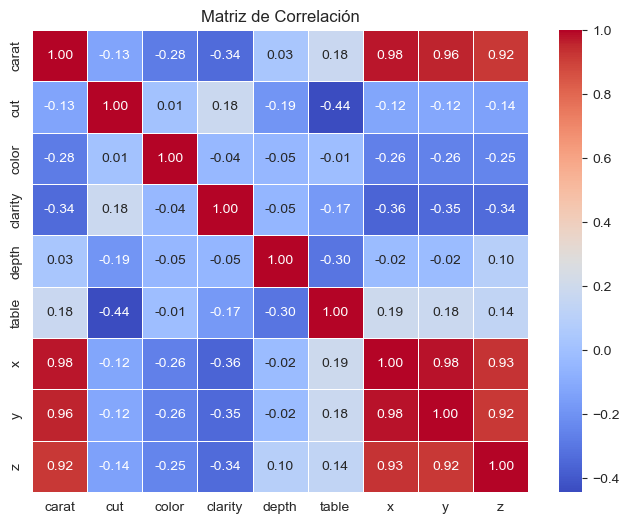

In [593]:
# Calcular la matriz de correlación
correlation_matrix = diamonds_test_x.corr()

# Configurar el tamaño de la figura
plt.figure(figsize=(8, 6))

# Crear un mapa de calor (heatmap) con seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Añadir título
plt.title('Matriz de Correlación')

# Mostrar el gráfico
plt.show()

In [594]:
# Escalado
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(diamonds_test_x)
diamonds_test_x_scaled = pd.DataFrame(scaled_data)
diamonds_test_x_scaled

,0,1,2,3,4,5,6,7,8
0,0.122661,0.50,0.666667,0.285714,0.421986,0.409091,0.298146,0.078592,0.074367
1,0.207900,1.00,0.000000,0.571429,0.361702,0.272727,0.439372,0.114154,0.091148
2,0.284823,0.75,0.333333,0.285714,0.404255,0.454545,0.520685,0.129445,0.103982
3,0.145530,0.50,0.666667,0.285714,0.460993,0.136364,0.336662,0.087127,0.081935
4,0.062370,0.50,0.666667,0.571429,0.429078,0.318182,0.188302,0.050142,0.058572
...,...,...,...,...,...,...,...,...,...
13480,0.076923,1.00,0.833333,0.285714,0.393617,0.227273,0.231098,0.058321,0.062192
13481,0.106029,1.00,0.166667,0.428571,0.404255,0.181818,0.282454,0.072902,0.070747
13482,0.103950,1.00,0.666667,0.571429,0.382979,0.181818,0.288160,0.072191,0.069760
13483,0.103950,0.50,0.666667,0.142857,0.283688,0.272727,0.302425,0.078592,0.067127


## Submission

In [601]:
model_random.fit(diamonds_train_x, diamonds_train_y)
y_pred = model_random.predict(diamonds_test_x)
y_pred

array([3001.6 , 5448.07, 9162.48, ..., 2969.5 , 2172.76,  864.59])

In [598]:
diamonds_test_x

,carat,cut,color,clarity,depth,table,x,y,z
0,0.79,3,5,3,62.7,60.0,5.82,5.89,3.67
1,1.20,5,1,5,61.0,57.0,6.81,6.89,4.18
2,1.57,4,3,3,62.2,61.0,7.38,7.32,4.57
3,0.90,3,5,3,63.8,54.0,6.09,6.13,3.90
4,0.50,3,5,5,62.9,58.0,5.05,5.09,3.19
...,...,...,...,...,...,...,...,...,...
13480,0.57,5,6,3,61.9,56.0,5.35,5.32,3.30
13481,0.71,5,2,4,62.2,55.0,5.71,5.73,3.56
13482,0.70,5,5,5,61.6,55.0,5.75,5.71,3.53
13483,0.70,3,5,2,58.8,57.0,5.85,5.89,3.45


In [596]:
diamonds_train_x

,carat,cut,color,clarity,depth,table,x,y,z
0,1.21,4,1,4,62.4,58.0,6.83,6.79,4.25
1,0.32,3,3,4,63.0,57.0,4.35,4.38,2.75
2,0.71,1,4,5,65.5,55.0,5.62,5.53,3.65
3,0.41,2,7,3,63.8,56.0,4.68,4.72,3.00
4,1.02,5,4,3,60.5,59.0,6.55,6.51,3.95
...,...,...,...,...,...,...,...,...,...
40450,1.34,5,4,5,62.7,57.0,7.10,7.04,4.43
40451,2.02,2,5,2,57.1,60.0,8.31,8.25,4.73
40452,1.01,5,3,3,62.7,56.0,6.37,6.42,4.01
40453,0.33,5,1,5,61.9,54.3,4.45,4.47,2.76


In [597]:
diamonds_train_y

0         4268
1          505
2         2686
3          738
4         4882
         ...  
40450    10070
40451    12615
40452     5457
40453      456
40454     6232
Name: price, Length: 40436, dtype: int64

In [602]:
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.reset_index(inplace=True)
y_pred_df.columns = ['id', 'price']
y_pred_df.to_csv('./data/submisions1.csv', index=False)

## Grid Search

In [1473]:
# Random Forest Regressor

param_grid = {'n_estimators': [100, 200, 300],  # Number of trees in the forest.
              'max_depth': [None, 3, 10],  # Maximum depth of the trees.
              'min_samples_split': [2, 10],  # Minimum number of samples required to split an internal node.
              'min_samples_leaf': [1, 4],  # Minimum number of samples required to be at a leaf node.
              'max_features': [None, 'sqrt', 'log2']  # Number of features to consider when looking for the best split.
              }

In [50]:
grid_search = GridSearchCV(model,
                           param_grid,
                           cv=5,
                           verbose=3,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1)

In [1475]:
%%time

grid_search.fit(diamonds_train_x_scaled,diamonds_train_y)

print('\n')
print('Best hyperparameters: ', grid_search.best_params_, '\n')
print('Best score: ', -grid_search.best_score_, '\n')

Fitting 5 folds for each of 108 candidates, totalling 540 fits


Best hyperparameters:  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300} 

Best score:  544.4170783126589 

CPU times: user 49.8 s, sys: 3.47 s, total: 53.3 s
Wall time: 52min 26s


In [ ]:
y_pred = model.predict(diamonds_test_x_scaled)

In [47]:
# Random Forest Regressor

param_grid = {'n_estimators': [500,700, 900],  # Number of trees in the forest.
              'max_depth': [None],  # Maximum depth of the trees.
              'min_samples_split': [5, 6, 8],  # Minimum number of samples required to split an internal node.
              'min_samples_leaf': [1],  # Minimum number of samples required to be at a leaf node.
              'max_features': [None]  # Number of features to consider when looking for the best split.
             }

In [ ]:
%%time

grid_search.fit(diamonds_train_x_scaled,diamonds_train_y)

print('\n')
print('Best hyperparameters: ', grid_search.best_params_, '\n')
print('Best score: ', -grid_search.best_score_, '\n')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
